# Импортирование библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import seaborn as sns
matplotlib.style.use('ggplot')

from sklearn.metrics import log_loss,roc_auc_score,f1_score,precision_score, recall_score,confusion_matrix,accuracy_score
from sklearn.metrics import average_precision_score

from sklearn.model_selection import train_test_split
from sklearn.utils import resample

from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.simplefilter(action = 'ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
def ignore_warn(*args, **kwargs):
    pass

warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)
  

# Необходимые функции

In [2]:
def score_calculation(X_train,y_train):
    lgb = LGBMClassifier(n_estimators=1500,learning_rate=0.01)
    lgb.fit(X_train,y_train,eval_set=(X_eval,y_eval),eval_metric='cross_entropy',
               early_stopping_rounds=150,verbose=False)
    
    rf_b = RandomForestClassifier(random_state=42)
    rf_b.fit(X_train,y_train)
    
    rf = RandomForestClassifier(random_state=42,bootstrap=False)
    rf.fit(X_train,y_train)
    
    score_f1 = [f1_score(y_test,lgb.predict(X_test)),
                f1_score(y_test,rf_b.predict(X_test)),
                f1_score(y_test,rf.predict(X_test))]
    score_pr = [average_precision_score(y_test,lgb.predict(X_test)),
                average_precision_score(y_test,rf_b.predict(X_test)),
                average_precision_score(y_test,rf.predict(X_test))]
    return score_f1, score_pr

# Немного о датасете
Датасет представляет из себя информацию о кредитных транзакциях, произведенных в течение двух дней владельцами банковских карт.

Колонка 'Time' представляет из себя количество секунд, прошедших между первой и рассматриваемой транзакцией. 

Переменная 'Amount' - не совсем денежная сумма, но данный признак напрямую зависит от нее. Будем считать это транзакцией, рассчитанной в долларах.

Признаки 'V*' - признаки, преобразованные с помощью метода главных компонент из данных, которые не могут быть выложены в открытый доступ. 

И, наконец, 'Class' - это интересующий нас признак. Нулевое значение определяет транзакцию как "чистую", а единичное как "мошенническую", которая и представляет наибольший интерес.

In [3]:
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
df.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

Распределение таргетовой переменной. На лицо явная задача о несбалансированных классах.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

Идеальный датасет: без пропусков и ошибочно-типовых значений.

Преобразуем переменную Time в часы для удобства.
Выделим 492 мошеннических транзакции в отдельный датафрейм.

In [6]:
df.Time = df.Time / 3600
df_pos = df[df.Class == 1]
df_pos.describe().iloc[1:,:]

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
mean,22.429669,-4.771948,3.623778,-7.033281,4.542029,-3.151225,-1.397737,-5.568731,0.570636,-2.581123,...,0.713588,0.014049,-0.040308,-0.105130,0.041449,0.051648,0.170575,0.075667,122.211321,1.0
std,13.287601,6.783687,4.291216,7.110937,2.873318,5.372468,1.858124,7.206773,6.797831,2.500896,...,3.869304,1.494602,1.579642,0.515577,0.797205,0.471679,1.376766,0.547291,256.683288,0.0
min,0.112778,-30.552380,-8.402154,-31.103685,-1.313275,-22.105532,-6.406267,-43.557242,-41.044261,-13.434066,...,-22.797604,-8.887017,-19.254328,-2.028024,-4.781606,-1.152671,-7.263482,-1.869290,0.000000,1.0
25%,11.455972,-6.036063,1.188226,-8.643489,2.373050,-4.792835,-2.501511,-7.965295,-0.195336,-3.872383,...,0.041787,-0.533764,-0.342175,-0.436809,-0.314348,-0.259416,-0.020025,-0.108868,1.000000,1.0
50%,20.991250,-2.342497,2.717869,-5.075257,4.177147,-1.522962,-1.424616,-3.034402,0.621508,-2.208768,...,0.592146,0.048434,-0.073135,-0.060795,0.088371,0.004321,0.394926,0.146344,9.250000,1.0
75%,35.689722,-0.419200,4.971257,-2.276185,6.348729,0.214562,-0.413216,-0.945954,1.764879,-0.787850,...,1.244611,0.617474,0.308378,0.285328,0.456515,0.396733,0.826029,0.381152,105.890000,1.0
max,47.318889,2.132386,22.057729,2.250210,12.114672,11.095089,6.474115,5.802537,20.007208,3.353525,...,27.202839,8.361985,5.466230,1.091435,2.208209,2.745261,3.052358,1.779364,2125.870000,1.0


Column:  Time

Values for positive classes: 
mean: 22.42967, std: 13.2876, 50%: 20.99125
min: 0.11278, max: 47.31889

Values for all dataset: 
mean: 26.33718, std: 13.19115, 50%: 23.52556
min: 0.0, max: 47.99778


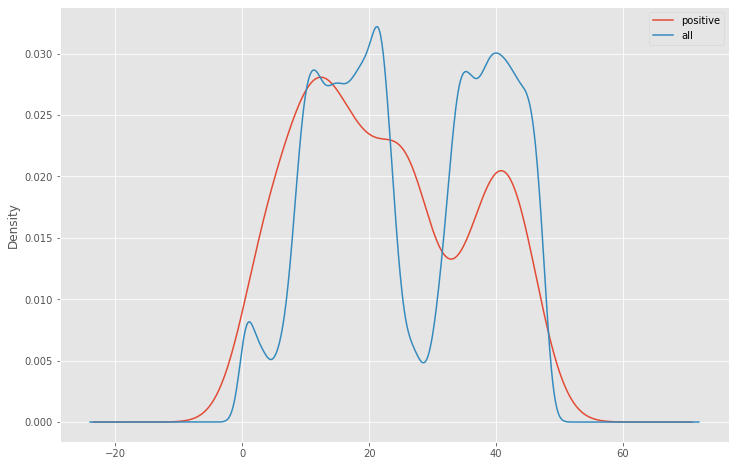




Column:  V1

Values for positive classes: 
mean: -4.77195, std: 6.78369, 50%: -2.3425
min: -30.55238, max: 2.13239

Values for all dataset: 
mean: 0.0, std: 1.9587, 50%: 0.01811
min: -56.40751, max: 2.45493


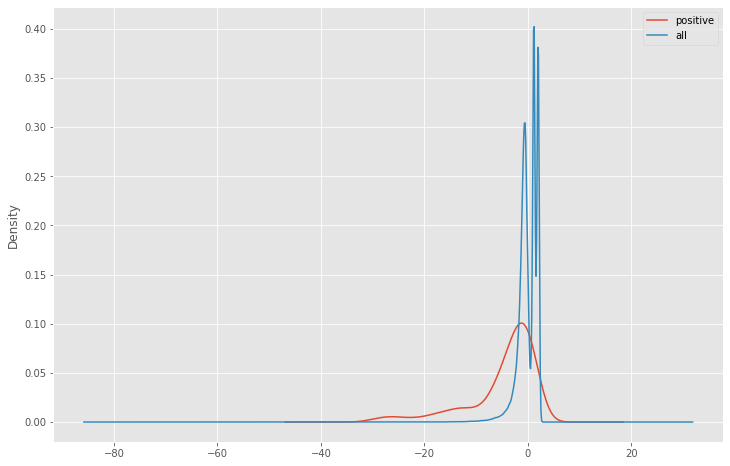




Column:  V2

Values for positive classes: 
mean: 3.62378, std: 4.29122, 50%: 2.71787
min: -8.40215, max: 22.05773

Values for all dataset: 
mean: 0.0, std: 1.65131, 50%: 0.06549
min: -72.71573, max: 22.05773


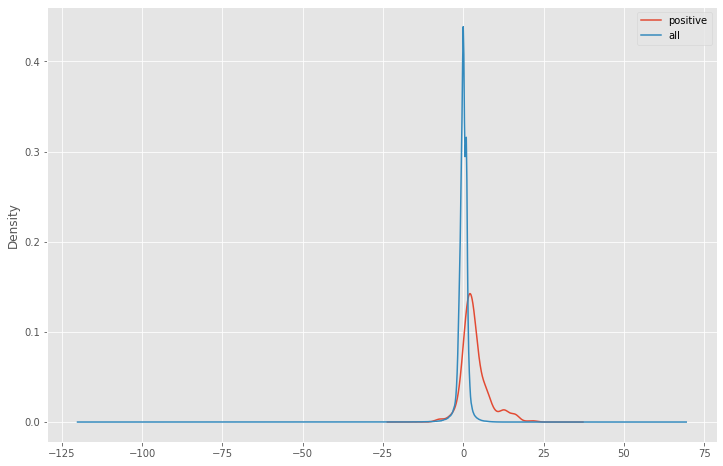




Column:  V3

Values for positive classes: 
mean: -7.03328, std: 7.11094, 50%: -5.07526
min: -31.10368, max: 2.25021

Values for all dataset: 
mean: -0.0, std: 1.51626, 50%: 0.17985
min: -48.32559, max: 9.38256


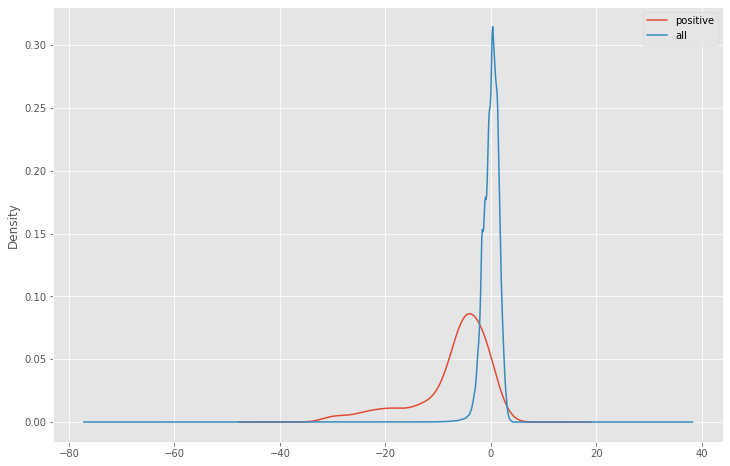




Column:  V4

Values for positive classes: 
mean: 4.54203, std: 2.87332, 50%: 4.17715
min: -1.31327, max: 12.11467

Values for all dataset: 
mean: 0.0, std: 1.41587, 50%: -0.01985
min: -5.68317, max: 16.87534


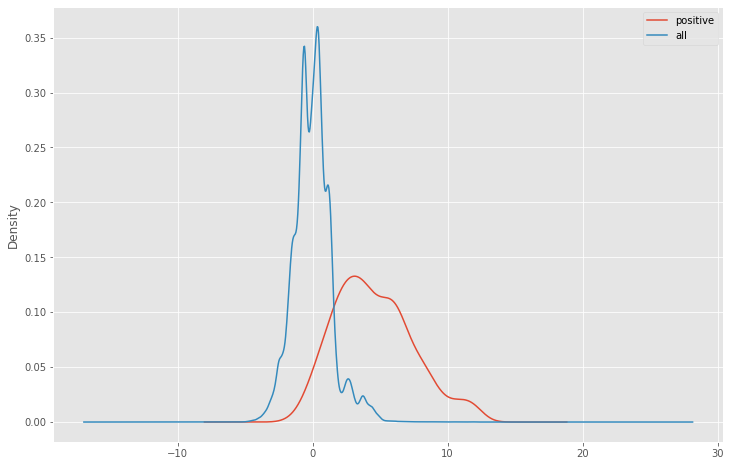




Column:  V5

Values for positive classes: 
mean: -3.15122, std: 5.37247, 50%: -1.52296
min: -22.10553, max: 11.09509

Values for all dataset: 
mean: 0.0, std: 1.38025, 50%: -0.05434
min: -113.74331, max: 34.80167


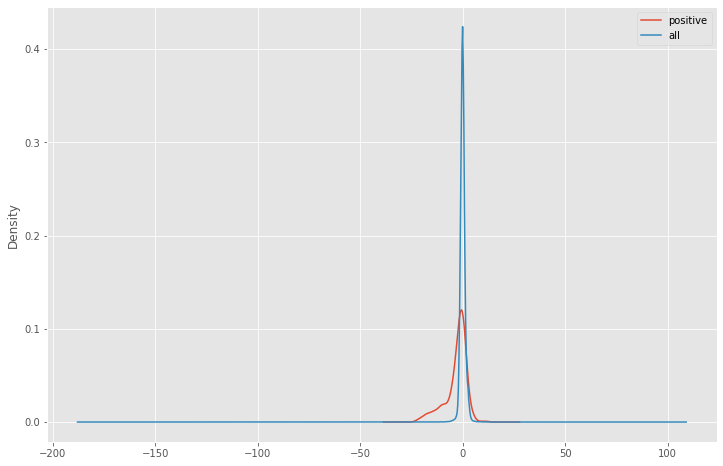




Column:  V6

Values for positive classes: 
mean: -1.39774, std: 1.85812, 50%: -1.42462
min: -6.40627, max: 6.47411

Values for all dataset: 
mean: 0.0, std: 1.33227, 50%: -0.27419
min: -26.16051, max: 73.30163


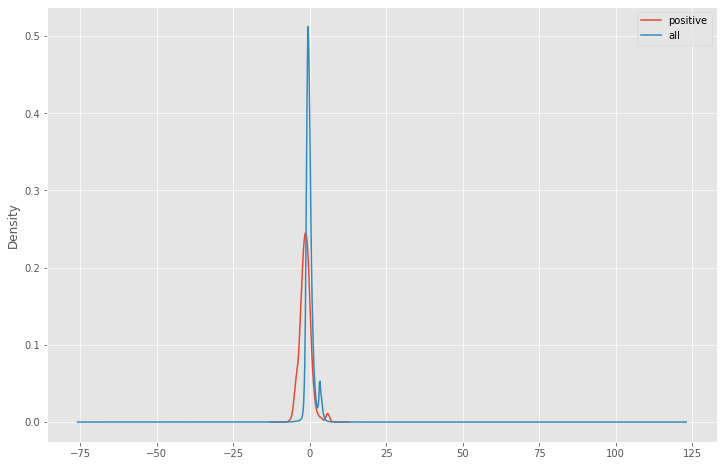




Column:  V7

Values for positive classes: 
mean: -5.56873, std: 7.20677, 50%: -3.0344
min: -43.55724, max: 5.80254

Values for all dataset: 
mean: -0.0, std: 1.23709, 50%: 0.0401
min: -43.55724, max: 120.58949


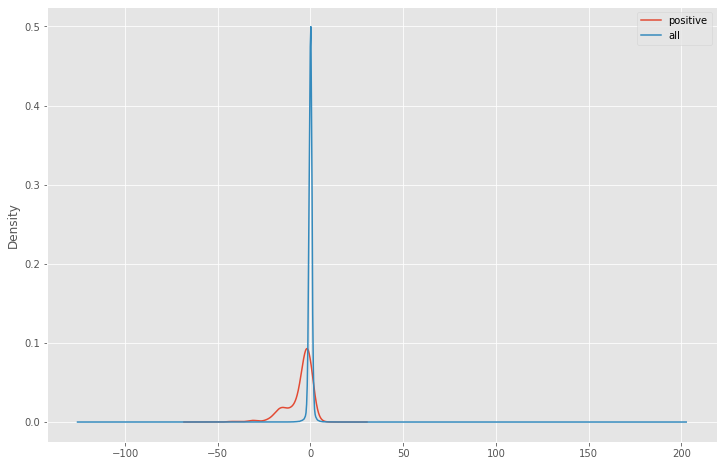




Column:  V8

Values for positive classes: 
mean: 0.57064, std: 6.79783, 50%: 0.62151
min: -41.04426, max: 20.00721

Values for all dataset: 
mean: 0.0, std: 1.19435, 50%: 0.02236
min: -73.21672, max: 20.00721


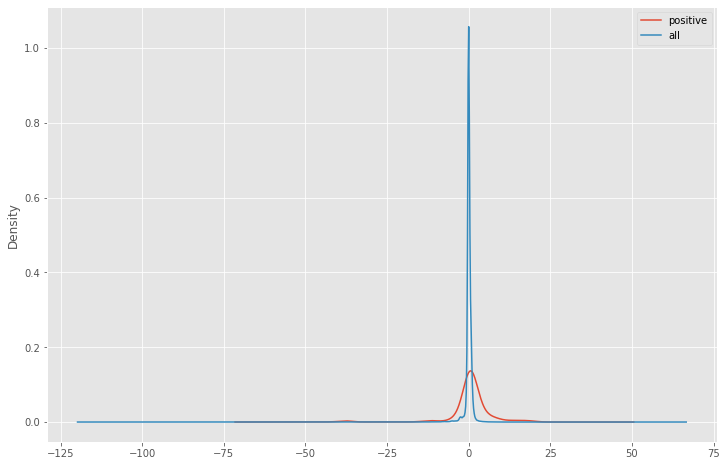




Column:  V9

Values for positive classes: 
mean: -2.58112, std: 2.5009, 50%: -2.20877
min: -13.43407, max: 3.35352

Values for all dataset: 
mean: -0.0, std: 1.09863, 50%: -0.05143
min: -13.43407, max: 15.59499


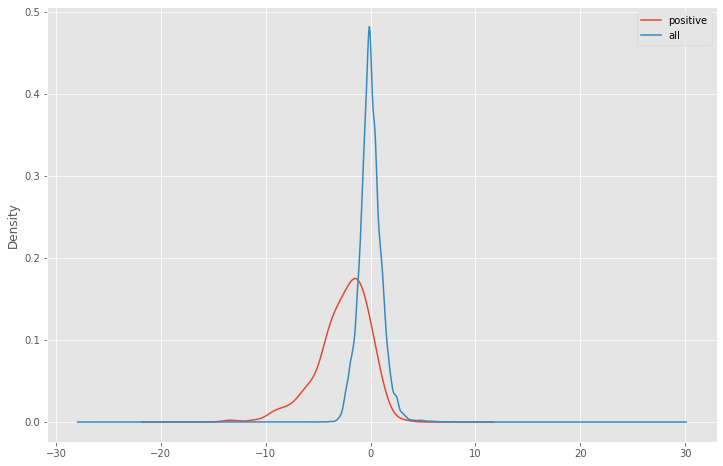




Column:  V10

Values for positive classes: 
mean: -5.67688, std: 4.89734, 50%: -4.57882
min: -24.58826, max: 4.03144

Values for all dataset: 
mean: 0.0, std: 1.08885, 50%: -0.09292
min: -24.58826, max: 23.74514


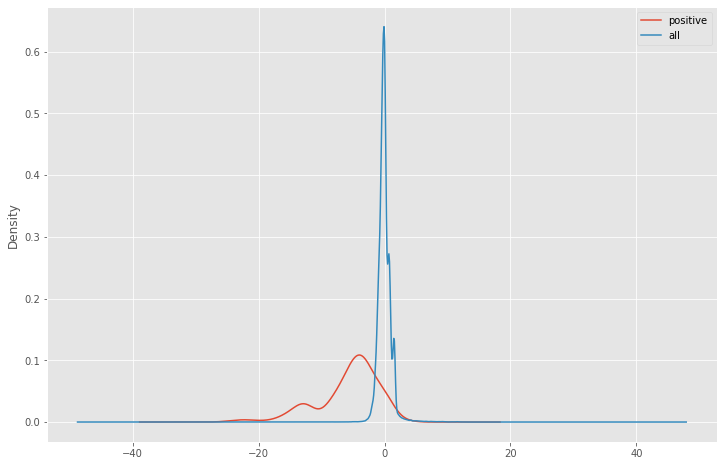




Column:  V11

Values for positive classes: 
mean: 3.80017, std: 2.6786, 50%: 3.58622
min: -1.70223, max: 12.01891

Values for all dataset: 
mean: 0.0, std: 1.02071, 50%: -0.03276
min: -4.79747, max: 12.01891


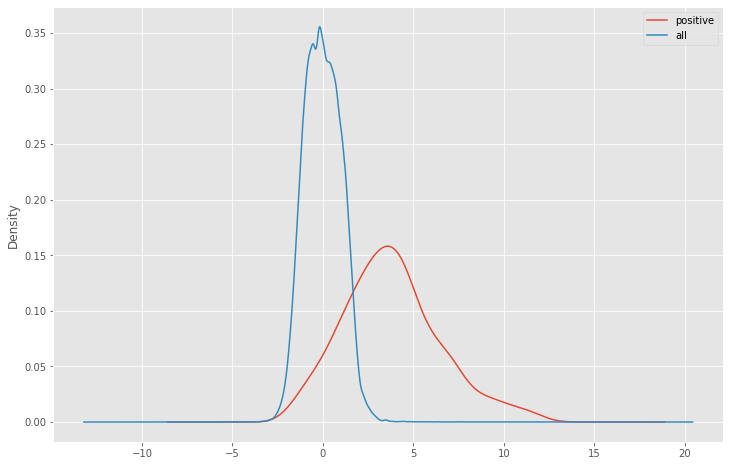




Column:  V12

Values for positive classes: 
mean: -6.25939, std: 4.65446, 50%: -5.50253
min: -18.68371, max: 1.37594

Values for all dataset: 
mean: -0.0, std: 0.9992, 50%: 0.14003
min: -18.68371, max: 7.84839


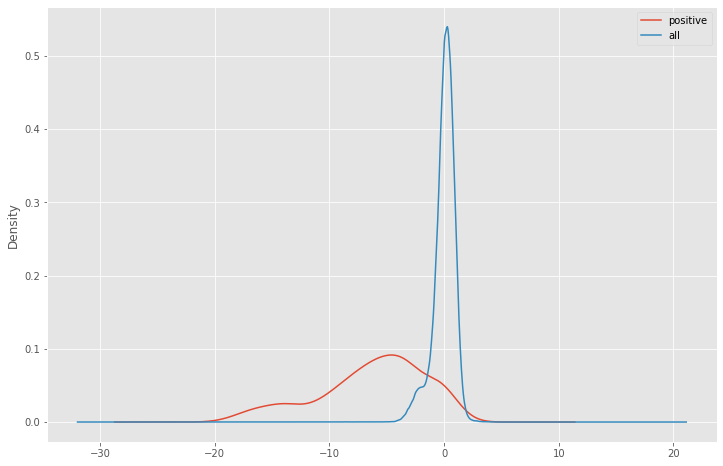




Column:  V13

Values for positive classes: 
mean: -0.10933, std: 1.10452, 50%: -0.06557
min: -3.1278, max: 2.81544

Values for all dataset: 
mean: 0.0, std: 0.99527, 50%: -0.01357
min: -5.79188, max: 7.12688


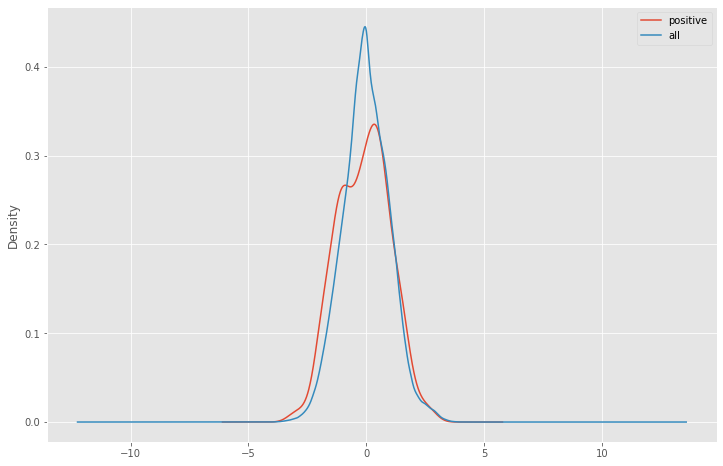




Column:  V14

Values for positive classes: 
mean: -6.97172, std: 4.27894, 50%: -6.72972
min: -19.21433, max: 3.44242

Values for all dataset: 
mean: 0.0, std: 0.9586, 50%: 0.0506
min: -19.21433, max: 10.52677


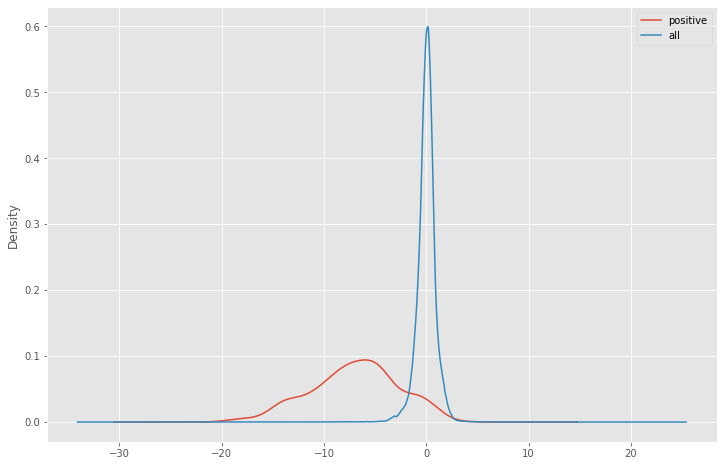




Column:  V15

Values for positive classes: 
mean: -0.09293, std: 1.04992, 50%: -0.05723
min: -4.49894, max: 2.47136

Values for all dataset: 
mean: 0.0, std: 0.91532, 50%: 0.04807
min: -4.49894, max: 8.87774


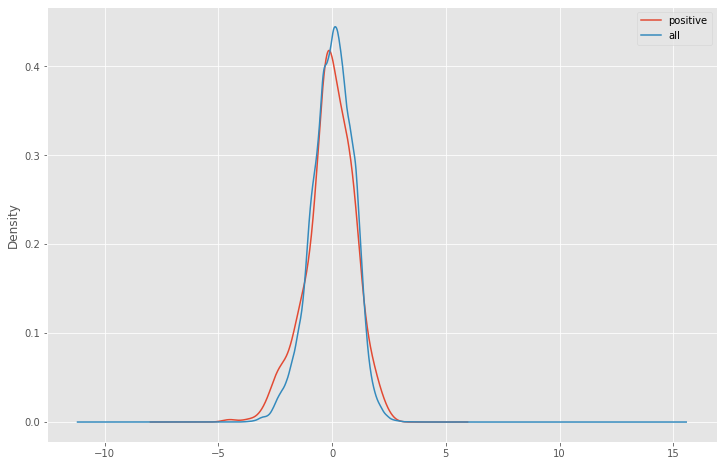




Column:  V16

Values for positive classes: 
mean: -4.13995, std: 3.86503, 50%: -3.54979
min: -14.12985, max: 3.13966

Values for all dataset: 
mean: 0.0, std: 0.87625, 50%: 0.06641
min: -14.12985, max: 17.31511


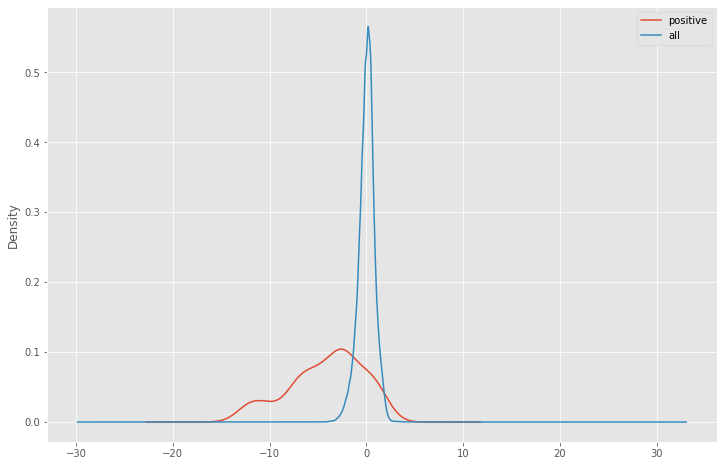




Column:  V17

Values for positive classes: 
mean: -6.66584, std: 6.97062, 50%: -5.30295
min: -25.1628, max: 6.73938

Values for all dataset: 
mean: -0.0, std: 0.84934, 50%: -0.06568
min: -25.1628, max: 9.25353


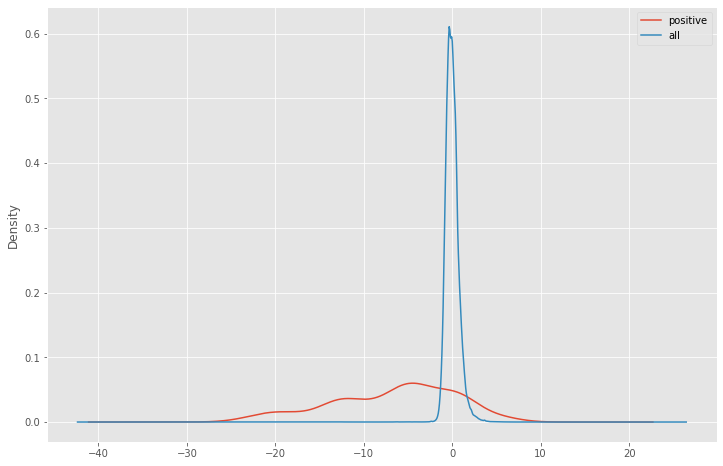




Column:  V18

Values for positive classes: 
mean: -2.24631, std: 2.89937, 50%: -1.66435
min: -9.49875, max: 3.79032

Values for all dataset: 
mean: 0.0, std: 0.83818, 50%: -0.00364
min: -9.49875, max: 5.04107


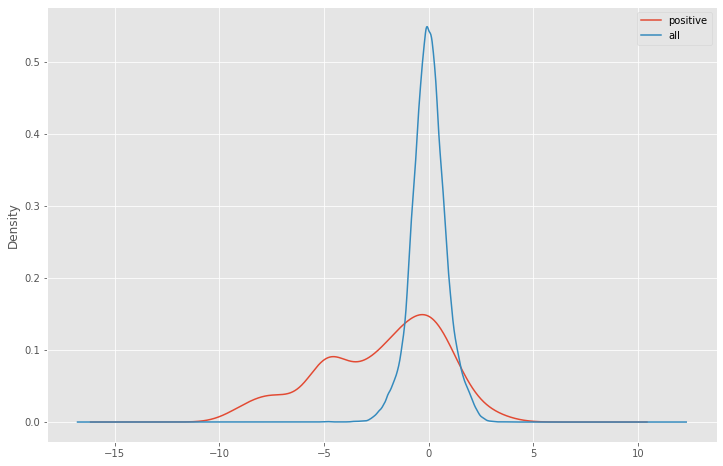




Column:  V19

Values for positive classes: 
mean: 0.68066, std: 1.53985, 50%: 0.64681
min: -3.6819, max: 5.22834

Values for all dataset: 
mean: 0.0, std: 0.81404, 50%: 0.00373
min: -7.21353, max: 5.59197


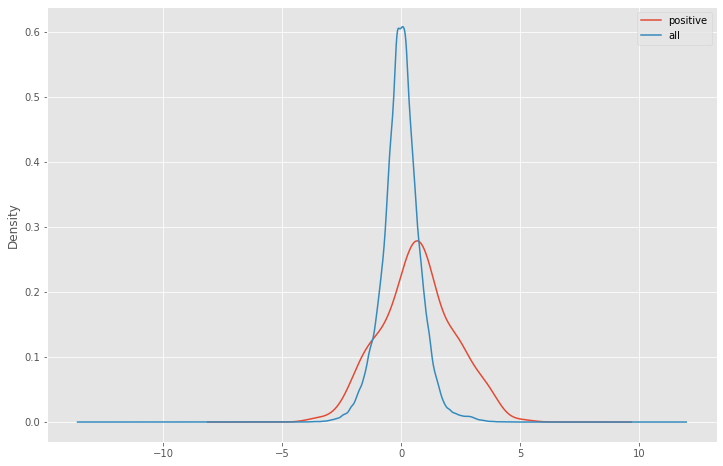




Column:  V20

Values for positive classes: 
mean: 0.37232, std: 1.34664, 50%: 0.28469
min: -4.12819, max: 11.059

Values for all dataset: 
mean: 0.0, std: 0.77093, 50%: -0.06248
min: -54.49772, max: 39.4209


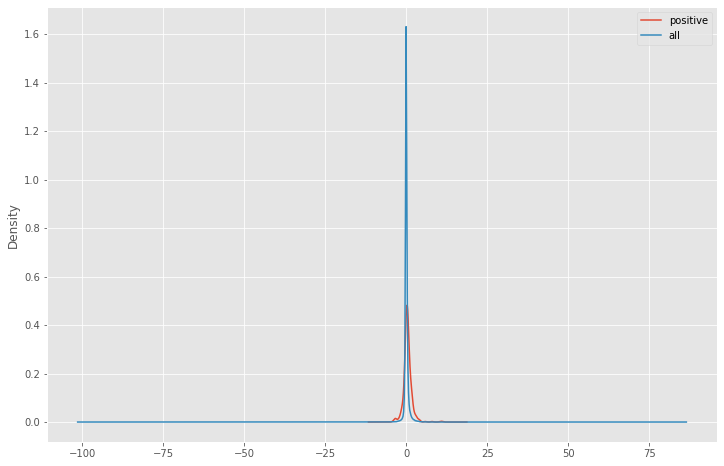




Column:  V21

Values for positive classes: 
mean: 0.71359, std: 3.8693, 50%: 0.59215
min: -22.7976, max: 27.20284

Values for all dataset: 
mean: 0.0, std: 0.73452, 50%: -0.02945
min: -34.83038, max: 27.20284


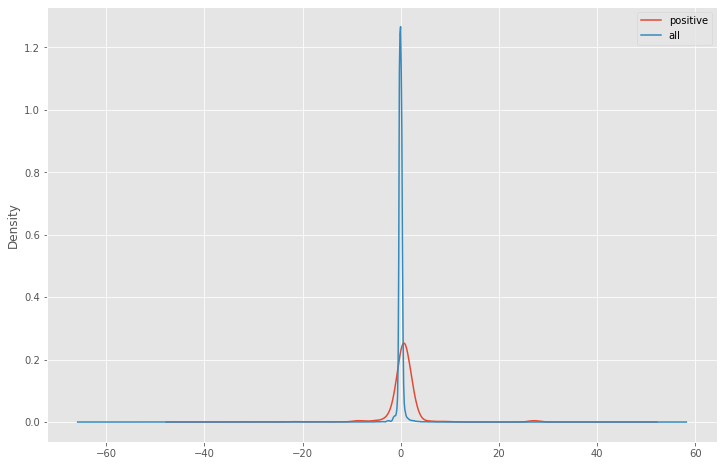




Column:  V22

Values for positive classes: 
mean: 0.01405, std: 1.4946, 50%: 0.04843
min: -8.88702, max: 8.36199

Values for all dataset: 
mean: -0.0, std: 0.7257, 50%: 0.00678
min: -10.93314, max: 10.50309


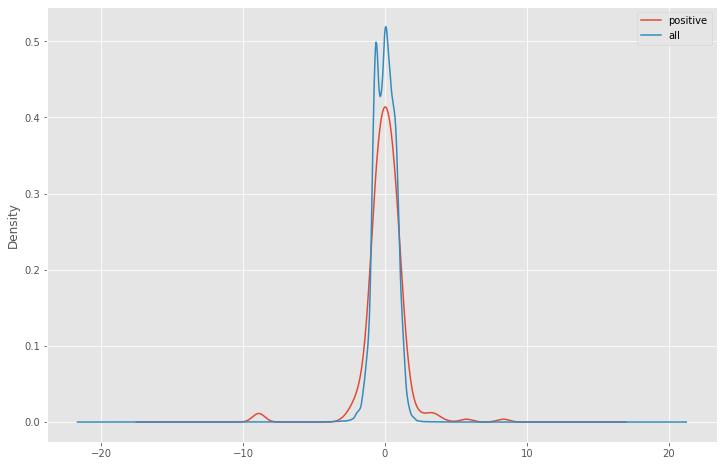




Column:  V23

Values for positive classes: 
mean: -0.04031, std: 1.57964, 50%: -0.07314
min: -19.25433, max: 5.46623

Values for all dataset: 
mean: 0.0, std: 0.62446, 50%: -0.01119
min: -44.80774, max: 22.52841


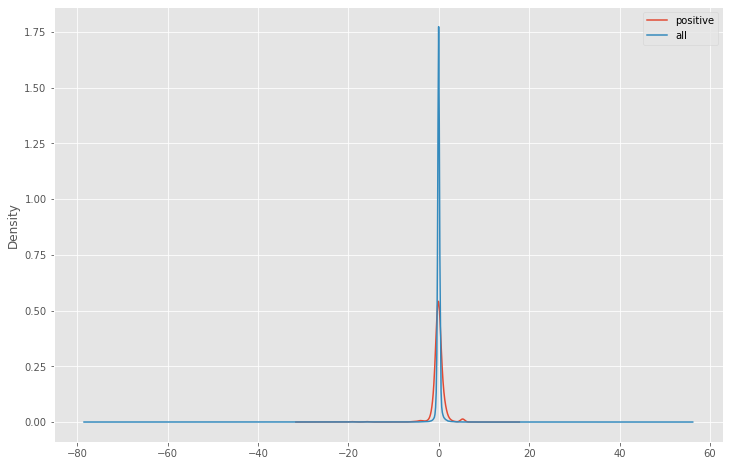




Column:  V24

Values for positive classes: 
mean: -0.10513, std: 0.51558, 50%: -0.0608
min: -2.02802, max: 1.09143

Values for all dataset: 
mean: 0.0, std: 0.60565, 50%: 0.04098
min: -2.83663, max: 4.58455


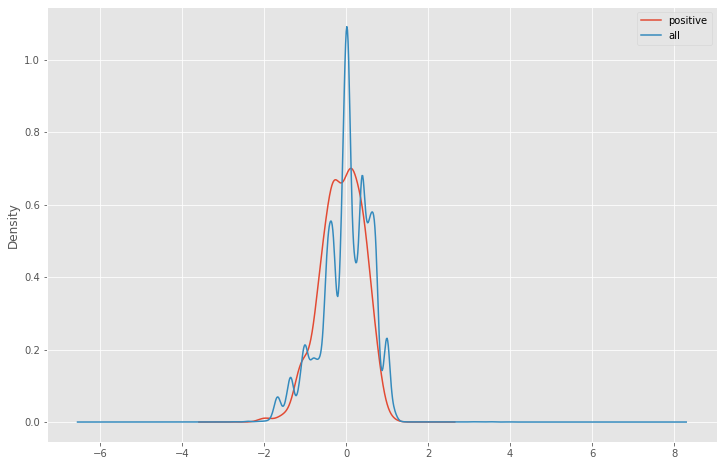




Column:  V25

Values for positive classes: 
mean: 0.04145, std: 0.7972, 50%: 0.08837
min: -4.78161, max: 2.20821

Values for all dataset: 
mean: 0.0, std: 0.52128, 50%: 0.01659
min: -10.2954, max: 7.51959


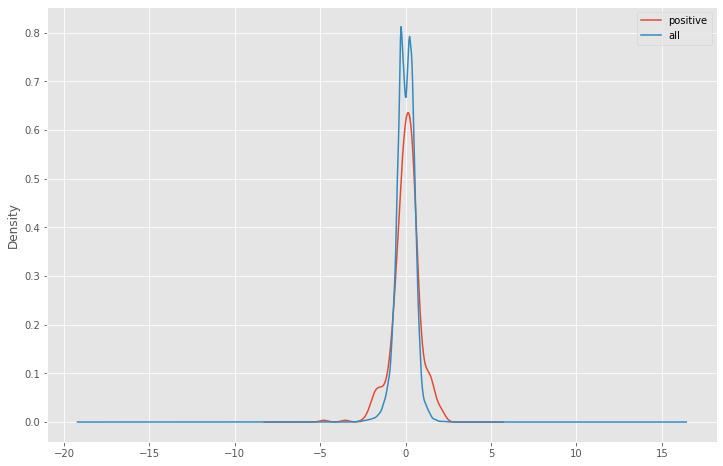




Column:  V26

Values for positive classes: 
mean: 0.05165, std: 0.47168, 50%: 0.00432
min: -1.15267, max: 2.74526

Values for all dataset: 
mean: 0.0, std: 0.48223, 50%: -0.05214
min: -2.60455, max: 3.51735


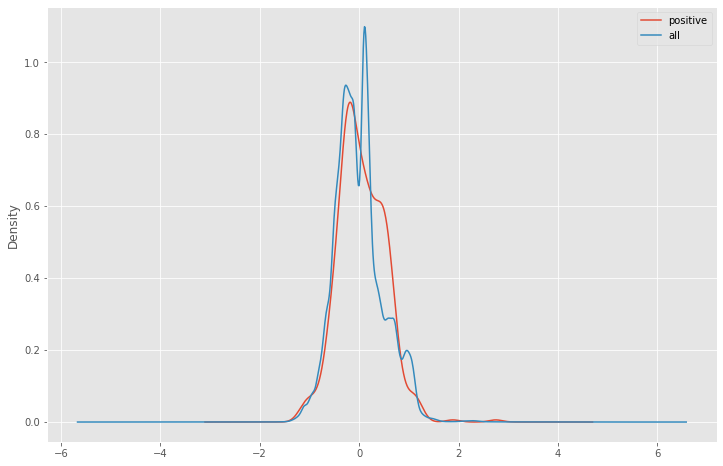




Column:  V27

Values for positive classes: 
mean: 0.17057, std: 1.37677, 50%: 0.39493
min: -7.26348, max: 3.05236

Values for all dataset: 
mean: -0.0, std: 0.40363, 50%: 0.00134
min: -22.56568, max: 31.6122


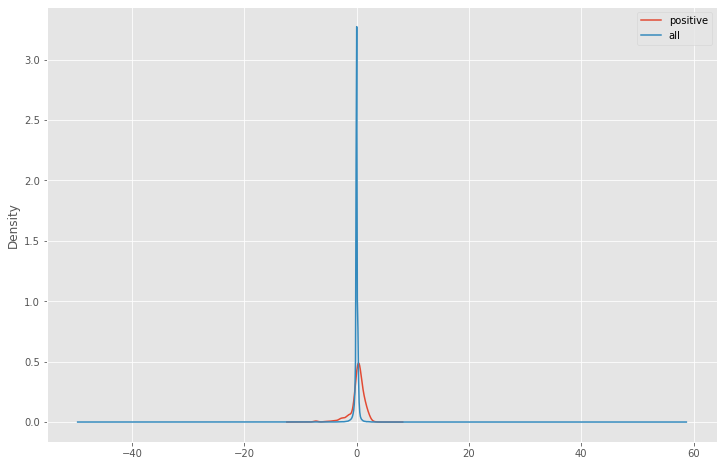




Column:  V28

Values for positive classes: 
mean: 0.07567, std: 0.54729, 50%: 0.14634
min: -1.86929, max: 1.77936

Values for all dataset: 
mean: -0.0, std: 0.33008, 50%: 0.01124
min: -15.43008, max: 33.84781


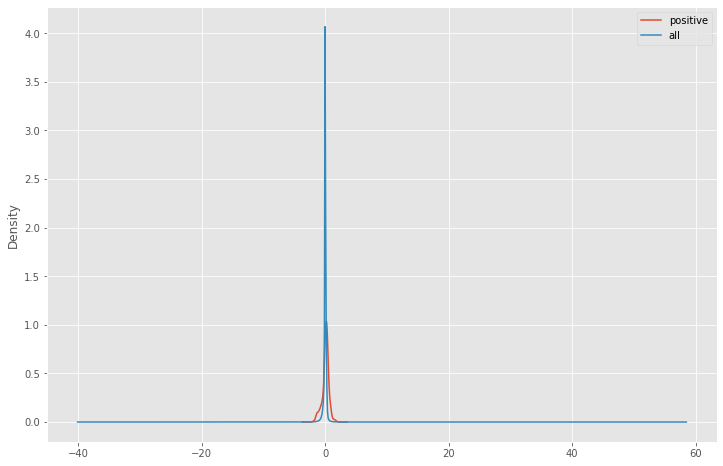




Column:  Amount

Values for positive classes: 
mean: 122.21132, std: 256.68329, 50%: 9.25
min: 0.0, max: 2125.87

Values for all dataset: 
mean: 88.34962, std: 250.12011, 50%: 22.0
min: 0.0, max: 25691.16


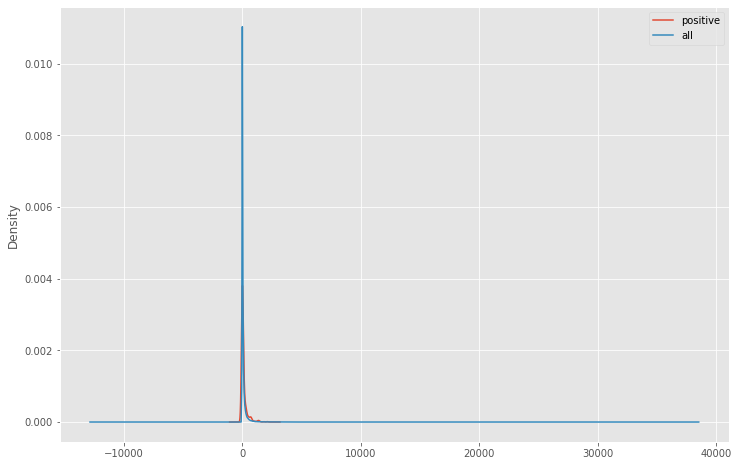

In [6]:
#не запускать
#не запускать
#не запускать

for column in df_pos.columns[:-1]:
    df_describe = df_pos.describe().iloc[1:,:][column]
    print('Column: ', column)
    print()
    print('Values for positive classes: ')
    print(f"mean: {round(df_describe['mean'],5)}, std: {round(df_describe['std'],5)}, 50%: {round(df_describe['50%'],5)}")
          
    print(f"min: {round(df_describe['min'],5)}, max: {round(df_describe['max'],5)}")
    df_describe = df.describe().iloc[1:,:][column]
    print()
    print('Values for all dataset: ')
    print(f"mean: {round(df_describe['mean'],5)}, std: {round(df_describe['std'],5)}, 50%: {round(df_describe['50%'],5)}")
          
    print(f"min: {round(df_describe['min'],5)}, max: {round(df_describe['max'],5)}")
    plt.figure(figsize=(12,8))
    df_pos[column].plot.kde(label='positive',x=column)
    df[column].plot.kde(label='all',x=column)
    plt.legend()
    plt.show()
    print('\n\n')

Наверное, первое, на что можно обратить внимание, это максимальное значение Amount. У мошеннических транзакций это число равно 2125.87$. Рассматривая весь датасет, максимальная сумма будет выше более чем в 10 раз. В этом есть логика, так как транзакции на большие суммы легче отследить и к тому же денежные махинации в пару долларов не так интересны банку, в сравнении с многотысячными. Запомним это.

Сравнивая два графика распределения главных компонент, видно, что максимальное значение плотности распределения всех транзакций гораздо выше, чем у мошеннических транзакций. Действительно, чем больше примеров мы рассматриваем, тем чаще они будут попадать в интервал нижней и верхней квантили. Нас больше интересуют случаи, когда графики плотностей распределения различаются, как например у признаков V12, V14. Медианные их значения достаточно далеки друг от друга. Такое различие позволит нам отбросить те примеры, которые для определения мошеннической транзакции являются шумовыми. И это мы тоже запомним.

Column: Time


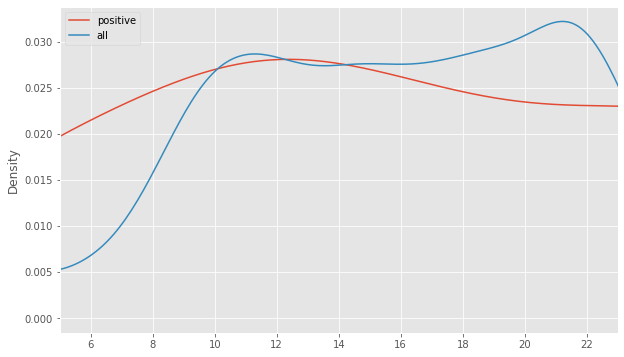

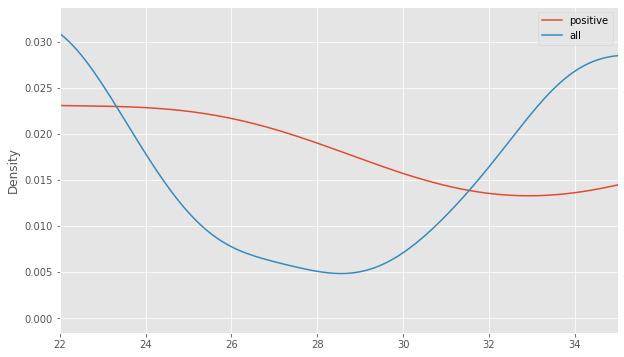

<Figure size 720x432 with 0 Axes>

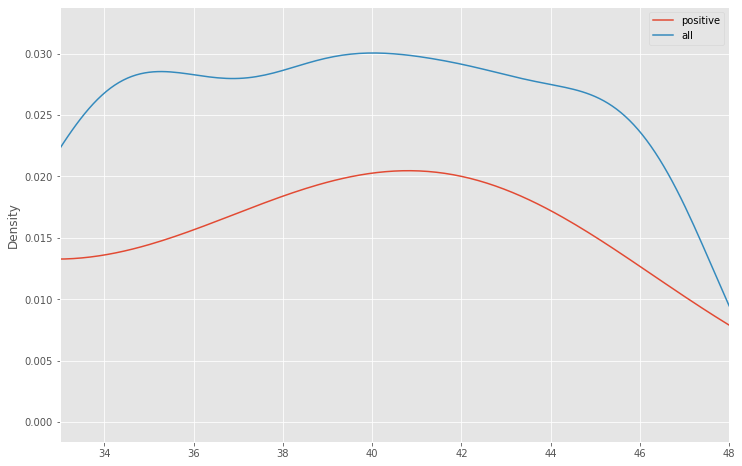

In [7]:
#не запускать
#не запускать
#не запускать

print('Column: Time')

plt.figure(figsize=(10,6))
df_pos['Time'].plot.kde(label='positive',x=column)
df['Time'].plot.kde(label='all',x=column)
plt.legend()
plt.xlim((5,23))
plt.show()

plt.figure(figsize=(10,6))
df_pos['Time'].plot.kde(label='positive',x=column)
df['Time'].plot.kde(label='all',x=column)
plt.legend()
plt.xlim((22,35))
plt.show()

plt.figure(figsize=(10,6))
plt.figure(figsize=(12,8))
df_pos['Time'].plot.kde(label='positive',x=column)
df['Time'].plot.kde(label='all',x=column)
plt.legend()
plt.xlim((33,48))
plt.show()

Отметим интересную особенность, что у распределения признака Time есть два пика в период с 10 до 22 часов и с 34 до 46 часов, а между ними большой 
провал. У распределения мошеннических операций также наблюдаются два пика, и пропасть, но коэффициент наклона в этой окрестности гораздо ниже, а второй пик гораздо меньше. В то же время у общего числа транзакций распределение пиковых значений примерно совпадает. Запомним и это.

# Идея и предобработка
Есть несколько идей решения задачи с несбалансированными классами. Для начала определимся с метрикой качества модели классификации. 

Поделим нашу выборку на обучающую и тестовую, и проверим значение accuracy, если наша модель будет кажому объекту из тестовой выборки выдавать нуль.

In [7]:
X = df.drop(['Class'],axis=1)
y = df.Class
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.27,shuffle=True,random_state=42,
                                                   stratify=y)

In [122]:
X_copy = X_train.copy()
y_copy = y_train.copy()

for column in df.columns[1:-2]:
    df_describe_pos = df_pos.describe().iloc[1:,:][column]
    df_describe = df.describe().iloc[1:,:][column]
    E = abs(df_describe_pos['50%'] - df_describe['50%'])
    D = abs(df_describe_pos['std'] - df_describe['std'])
    if (E > 3) and (D > 3):
        X_train = X_train[(X_train[column] > X_train[y_train == 1][column].quantile(0.005))&
                (X_train[column] < X_train[y_train == 1][column].quantile(0.995))]
y_train = y_train[X_train.index]

In [135]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42, sampling_strategy = 0.01)
X_train, y_train = sm.fit_sample(X_train, y_train)

In [136]:
X_train, X_eval,y_train,y_eval = train_test_split(X_train,y_train,test_size=0.2,shuffle=True,random_state=42,
                                                 stratify=y_train)
print('  ON TEST value counts: ')
print(f'Class == 0: {y_test.value_counts()[0]}, Class == 1: {y_test.value_counts()[1]}\n')
acc = accuracy_score(y_test,np.zeros(y_test.shape[0]))
print('  All zeros: ')
print(f"Accuracy: \t{acc}")

  ON TEST value counts: 
Class == 0: 76765, Class == 1: 133

  All zeros: 
Accuracy: 	0.9982704361621889


In [137]:
from xgboost import XGBClassifier

xgb = XGBClassifier(n_estimators=1500,learning_rate=0.01)
xgb.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_eval,y_eval)],
               early_stopping_rounds=150,verbose=False)
average_precision_score(y_test,xgb.predict(X_test))
f1_score(y_test,xgb.predict(X_test))

0.8571428571428571

In [138]:
print(average_precision_score(y_test,xgb.predict(X_test)))
f1_score(y_test,xgb.predict(X_test))

0.7355170277454596


0.8571428571428571

В этом и заключается основная проблема работы с несбалансированными классами. Ошибочно полагаться в данном случае на accuracy меру, ведь мы не предсказали ни одной махинации, однако метрика выдает нам значение, близкое к единице. 

Вообще говоря, использовать долю правильных ответов как оценку алгоритма на тесте не имеет смысла, только если наши классы не сбалансированы. И даже в этом случае выгодней использовать другие метрики, ведь иногда нужно максимизировать количество угаданных позитивных классов, не сильно заботясь об ошибках второго рода. За этим используются precision и recall метрики, которые комбинируются в F1-меру. 


Основные идеи борьбы с несбалансированными классами это: подбор правильных алгоритмов машинного обучение, оценивая ее правильной метрикой качества, oversampling, downsampling. 

Методы оверсемплинга и даунсемплинга направлены на балансировку распределения таргетовой переменной и на увеличение, уменьшение обучающей выборки соответственно. Рассмотрим два алгоритма: градиентный бустинг библиотеки lightgbm и случайный лес, без подбора гиперпараметров. Обучим эти алгоритмы на измененных выборках и проверим их на заранее отложенных тестовых. Оценкой качества алгоритма будет служить F1-мера, которая достаточно чувствительна к количеству предсказанных положительных классов. ROC-AUC мера, вообще говоря, в задачах большого перекоса выборки в сторону отрицательного класса, бесполезна. Альтернативой является AUC-PR (Precision-Recall). Идея построения кривой похожая, но по осям координат вместо FPR и TPR откладываются полнота и точность. Площадь под кривой, близкая к единице, соответствует идеальному алгоритму.

In [9]:
X_with_y = pd.concat([X_train, y_train], axis=1)

downsampled = resample(X_with_y[X_with_y.Class==0],replace = False,
                                 n_samples = X_with_y[X_with_y.Class==1].shape[0], random_state = 42)
downsampled = pd.concat([downsampled, X_with_y[X_with_y.Class==1]])

print(f'  After downsampling:\n{downsampled[downsampled.Class == 1].shape[0]} positive classes')
print(f'{downsampled[downsampled.Class == 0].shape[0]} negative classes\n')


upsampled = resample(X_with_y[X_with_y.Class==1],
                          replace=True,n_samples=X_with_y[X_with_y.Class==0].shape[0], 
                          random_state=42) 
upsampled = pd.concat([upsampled, X_with_y[X_with_y.Class==0]])

print(f'  After upsampling:\n{upsampled[upsampled.Class == 1].shape[0]} positive classes')
print(f'{upsampled[upsampled.Class == 0].shape[0]} negative classes')

  After downsampling:
287 positive classes
287 negative classes

  After downsampling:
287 positive classes
287 negative classes

  After upsampling:
166040 positive classes
166040 negative classes


Посмотрим на результаты работы алгоритмов при разных размерах даунсемплинга, оверсемплинга и без них. 

In [ ]:
#не запускать
#не запускать
#не запускать

weight = ['pos_classes_' + str(287*2**i) for i in range(10)]
weight.append('pos_classes_' + str(166040))
weight1 = ['neg_classes_' + str(287*2**i) for i in range(10)]
weight1.append('neg_classes_' + str(166040))
weight1.append('no preprocessing')
testing_df_pr = pd.DataFrame([],index=weight+weight1,columns=['lgb','rf_bootstrap','rf_no_bootstrap'])


weight = ['pos_classes_' + str(287*2**i) for i in range(10)]
weight.append('pos_classes_' + str(166040))
weight1 = ['neg_classes_' + str(287*2**i) for i in range(10)]
weight1.append('neg_classes_' + str(166040))
weight1.append('no preprocessing')
testing_df_f1 = pd.DataFrame([],index=weight+weight1,columns=['lgb','rf_bootstrap','rf_no_bootstrap'])

X_with_y = pd.concat([X_train, y_train], axis=1)

score_f1, score_pr = score_calculation(X_train,y_train)
testing_df_f1.iloc[-1,:] = score_f1
testing_df_pr.iloc[-1,:] = score_pr


for i in tqdm(range(len(list_for_loops))):
    

    downsampled = resample(X_with_y[X_with_y.Class==0],replace = False,
                                     n_samples = list_for_loops[i], random_state = 42)
    downsampled = pd.concat([downsampled, X_with_y[X_with_y.Class==1]])

    upsampled = resample(X_with_y[X_with_y.Class==1],
                              replace=True,n_samples=list_for_loops[-1-i], random_state=42) 
    upsampled = pd.concat([upsampled, X_with_y[X_with_y.Class==0]])

    X_down = downsampled.drop(['Class'],axis=1)
    y_down = downsampled.Class

    X_up = upsampled.drop(['Class'],axis=1)
    y_up = upsampled.Class
    
    score_f1_down, score_pr_down = score_calculation(X_down,y_down)#функция подсчетa метрики качества (F1, ROC-AUC)
    score_f1_up, score_pr_up = score_calculation(X_up,y_up) 
    testing_df_f1.loc[weight1[i],:] = score_f1_down
    testing_df_pr.loc[weight1[i],:] = score_pr_down

    testing_df_f1.loc[weight[-1-i],:] = score_f1_up
    testing_df_pr.loc[weight[-1-i],:] = score_pr_up
    
testing_df = pd.concat([testing_df_f1,testing_df_pr],axis=1)
testing_df.columns = ['lgb_f1','rf_bootstrap_f1','rf_no_bootstrap_f1',
                      'lgb_auc','rf_bootstrap_auc','rf_no_bootstrap_auc']
testing_df.to_csv('testing_df.csv')

In [26]:
testing_df = pd.read_csv('testing_df.csv')
#testing_df.columns[0] = 'classes'
testing_df.index = testing_df['Unnamed: 0']
testing_df.drop(['Unnamed: 0'],axis=1,inplace=True)
testing_df

,lgb_f1,rf_bootstrap_f1,rf_no_bootstrap_f1,lgb_auc,rf_bootstrap_auc,rf_no_bootstrap_auc
Unnamed: 0,,,,,,
pos_classes_287,0.794643,0.847458,0.855932,0.655038,0.730409,0.745069
pos_classes_574,0.851240,0.863071,0.858333,0.732197,0.753371,0.745875
pos_classes_1148,0.860656,0.855967,0.861925,0.747164,0.739680,0.752908
pos_classes_2296,0.868852,0.869919,0.866667,0.761443,0.762132,0.760408
pos_classes_4592,0.861789,0.868852,0.847458,0.747972,0.761443,0.730409
pos_classes_9184,0.869565,0.864198,0.857143,0.758444,0.753953,0.745409
pos_classes_18368,0.866142,0.857143,0.846154,0.752179,0.745409,0.730063
pos_classes_36736,0.854902,0.850000,0.842553,0.732532,0.731483,0.722910
pos_classes_73472,0.870588,0.838983,0.832618,0.759623,0.715896,0.707912


Здесь строки 'pos_classes_...', 'neg_classes_...' соответствуют результатам работы алгоритмов на тестовой выборке при изменении количества сэмплов позитивных и отрицательных классов соответсвенно. Говоря в общем о "чистых" и мошеннических транзакция, будем их называть отрицательными и позитивными классами, для удобства

В целом даунсемплинг работает хуже. При малом количестве отрицательных классов алгоритмам не хватает обобщающей способности для предсказания выборки с 76898 строками.